# Axisymmetric JAM modeling of synthetic lens set

In [1]:
import numpy as np

import pandas as pd
import corner
from copy import deepcopy
import h5py

import matplotlib.pyplot as plt

from cycler import cycler
import matplotlib as mpl
clist = ['#04B2D9', '#F2B33D', '#F29966', '#F2441D', '#0486C5']
mpl.rcParams['axes.prop_cycle'] = cycler(color=clist)

In [2]:
from deproject.Profiles.SIS_truncated_physical import SIS_truncated_physical
from deproject.Util.orientation import Isotropic_inclination
from deproject.Profiles.Jaffe import Jaffe
from deproject.Cosmo.default_cosmo import get_default_lens_cosmo
from deproject.MGE_analysis.mge_proj import MGE_Proj
from deproject.MGE_analysis.intr_mge import Intr_MGE
from deproject.MGE_analysis.mge_misc import sum_gaussian_components
from deproject.Util.ellipticity import Axis_ratio2ellipticity

from jampy.jam_axi_proj import jam_axi_proj
from jampy.mge_half_light_isophote import mge_half_light_isophote

from plotbin.plot_velfield import plot_velfield

from mgefit.mge_fit_1d import mge_fit_1d

from lenstronomy.Analysis.lens_profile import LensProfileAnalysis

## Calculation

In [3]:
def get_truncsis_intr_mge(sigma_v, rc_kpc, r_sym, qintr, plot_mge=0, fignum=1):
    """get the amplitude and dispersion of the MGE describing the INTRINSIC mass density/stellar light profile along the symmetry axis 

    Args:
        sigma_v (_type_): sigma_sph of the truncated SIS profile
        rc_kpc (_type_): truncation radius in kpc
        r_sym (_type_): coordinate along the symmetry axis
        qintr (_type_): intrinsic axis ratio. If oblate, qintr < 1; if prolate, qintr > 1
        plot_mge (int, optional): _description_. Defaults to 0.
        fignum (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: amplitude in M_sun/pc^3
        _type_: dispersion in pc
    """
    sis_profile = SIS_truncated_physical(sigma_v=sigma_v, rc = rc_kpc)
    intr_mge = Intr_MGE(profile=sis_profile, qintr=qintr, r_sym=r_sym)
    peak, sigma = intr_mge.MGE_param(kwargs_mge={'ngauss': 20, 'inner_slope': 3, 'outer_slope':1}, plot_mge=plot_mge, fignum=fignum)

    peak = peak / 1e9 # convert to [M_sun/pc^3]
    sigma = sigma * 1e3 # convert to [pc]

    return peak, sigma

In [4]:
def get_proj_mge(mge_proj, distance, inc):
    """get projected MGE

    Args:
        mge_proj (_type_): MGE_proj instance
        distance (_type_): angular diameter distance in Mpc, used to convert the dispersion to arcsec
        inc (_type_): inclination angle [rad]

    Returns:
        _type_: peak of the projected MGE [M_sun/pc^3]
        _type_: sigma of the projected MGE [arcsec]
        _type_: projected axis ratio 
    """
    surf = mge_proj.surf(inc=inc)
    qobs = mge_proj.qobs(inc=inc)

    qobs = np.full_like(surf, qobs)

    pc = distance * np.pi / 0.648 # convert to arcsec
    sigma_intr = mge_proj.sigma
    sigma = sigma_intr / pc

    return surf, sigma, qobs

In [5]:
def get_jaffe_intr_mge(m_star, rs_kpc, qintr, plot_mge=0, fignum=1):

    jaffe_profile = Jaffe(rs=rs_kpc, rho0=1e5)

    r_sym = np.geomspace(0.001, 10 * rs_kpc, 300)

    intr_mge = Intr_MGE(profile=jaffe_profile, qintr=qintr, r_sym=r_sym)

    peak, sigma = intr_mge.MGE_param(kwargs_mge = {'ngauss': 20}, plot_mge=plot_mge, fignum=fignum)

    peak = peak / 1e9 # convert to [M_sun/pc^3]
    sigma = sigma * 1e3 # convert to [pc]

    mtot = intr_mge.MGE_mass_sph()
    peak = m_star / mtot * peak # rescale to desired input stellar mass

    return peak, sigma

In [6]:
def get_sigma_e(surf_lum, sigma_lum, qobs_lum, jam, xbin, ybin, plot_velmap=0, plot_sample_points=0, fignum=1):
    """calculate velocity dispersion within the half-light radius from a jam model

    Args:
        surf_lum (_type_): peak of surface luminosity MGE 
        sigma_lum (_type_): sigma of surface luminocity MGE
        qobs_lum (_type_): array of the projected axis raio of the surface luminosity MGEs
        jam (_type_): jam model, a jampy.jam_axi_proj instance
        xbin (_type_): x coordinate to sample the velocity dispersion
        ybin (_type_): y coordinate to sample the velocity dispersion
        plot_velmap (int, optional): whether to plot the velocity dispersion map. Defaults to 0.
        plot_sample_points (int, optional): whether to plot the xy coordinates within the half-light radius. Defaults to 0.
        fignum (int, optional): _description_. Defaults to 1.

    Raises:
        ValueError: _description_

    Returns:
        _type_: _description_
    """
    ifu_dim = int(np.sqrt(len(xbin)))
    if np.all(qobs_lum <= 1):
        flux = jam.flux
    elif np.all(qobs_lum > 1):
        flux = np.reshape(jam.flux, (ifu_dim, ifu_dim)).T  # for prolate rotate the flux map by 90 degrees to calculate the half-light radius
        flux = flux.flatten() 
    else:
        raise ValueError('Apparent axis ratio must be constant with radius!')

    reff, reff_maj, eps_e, lum_tot = mge_half_light_isophote(surf_lum, sigma_lum, qobs_lum)

    w = xbin**2 + ybin**2 < reff**2

    model = jam.model

    sig_e = np.sqrt((flux[w]*model[w]**2).sum()/flux[w].sum())

    if plot_velmap:
        plt.figure(fignum)
        plot_velfield(xbin, ybin, model, flux=flux, nodots=1, colorbar=1)
        ax = plt.gca()
        if plot_sample_points:
            ax.plot(xbin[w], ybin[w], ',')
        ax.set_xlabel('arcsec')
        ax.set_ylabel('arcsec')
    return sig_e

In [7]:
def get_sigma_e_dist(data, oblate, save_mge=0):
    
    # set up a cosmology and lens_source configuration
    lens_cosmo = get_default_lens_cosmo()
    distance = lens_cosmo.Dd
    sigma_crit = lens_cosmo.Sigma_crit / 1e12 # [M_sun/pc^2]

    num_galaxy = data.shape[1]
    num_proj = num_galaxy
    sigma_e_all = np.zeros(num_proj)
    qobs_all = np.zeros(num_proj)
    theta_e_all = np.zeros(num_proj)

    if save_mge:
        peak_mge_den_all = np.zeros(shape=(num_proj, 20))
        sigma_mge_den_all = np.zeros_like(peak_mge_den_all)
        peak_mge_lum_all = np.zeros(shape=(num_proj, 20))
        sigma_mge_lum_all = np.zeros_like(peak_mge_lum_all)

    # access catalog info
    sigma_rm_all = data[0]
    rs_kpc_all = data[1] / 0.763
    if oblate:
        qintr_all = data[2]
    else:
        qintr_all = 1/data[2]
    # compute rc_kpc for truncated sis profile
    theta_e_sis_all = lens_cosmo.sis_sigma_v2theta_E(sigma_rm_all)
    theta_e_sis_kpc_all = lens_cosmo.arcsec2Mpc_lens(theta_e_sis_all) * 1e3
    rc_kpc_all = theta_e_sis_kpc_all * 200

    # sample inclination angle uniformly on a sphere
    inc_all = Isotropic_inclination(num_proj, 1, 0)
    inc_deg_all = np.degrees(inc_all)

    for i in range(num_galaxy):

        sigma_rm = sigma_rm_all[i]
        rs_kpc = rs_kpc_all[i]
        qintr = qintr_all[i]
        rc_kpc = rc_kpc_all[i]
        theta_e_sis = theta_e_sis_all[i]
        inc = inc_all[i]
        inc_deg = inc_deg_all[i]

        # intrinsic MGE component of density and luminosity
        r_sym = np.geomspace(0.01, 5 * rc_kpc, 300)
        r_fine = np.geomspace(0.01, 10 * theta_e_sis, 100)
        peak_den, sigma_den = get_truncsis_intr_mge(sigma_rm, rc_kpc, r_sym, qintr)
        peak_lum, sigma_lum = get_jaffe_intr_mge(1e11, rs_kpc, qintr)

        beta = np.zeros_like(peak_lum)

        # project each single_proj times
        mge_proj_den = MGE_Proj(peak_den, sigma_den, qintr)
        mge_proj_lum = MGE_Proj(peak_lum, sigma_lum, qintr)

        # make a grid
        xx = np.linspace(-2.5 * theta_e_sis, 2.5 * theta_e_sis, 100)  # avoid (x,y)=(0,0)
        xbin, ybin = map(np.ravel, np.meshgrid(xx, xx))

        peak_surf_den, sigma_surf_den, qobs_den = get_proj_mge(mge_proj_den, distance, inc)
        peak_surf_lum, sigma_surf_lum, qobs_lum = get_proj_mge(mge_proj_lum, distance, inc)

        # save the mge
        if save_mge:
            peak_mge_den_all[i, :len(peak_surf_den)] =  peak_surf_den
            sigma_mge_den_all[i, :len(sigma_surf_den)] = sigma_surf_den
            peak_mge_lum_all[i, :len(peak_surf_lum)] = peak_surf_lum
            sigma_mge_lum_all[i, :len(sigma_surf_lum)] = sigma_surf_lum

        # compute observed axis ratio 
        Qobs = mge_proj_den.qobs(inc=inc)
        qobs_all[i] = Qobs

        # compute einstein radius from the radial profile
        surf_den_circ = sum_gaussian_components(r_fine/np.sqrt(Qobs), peak_surf_den, sigma_surf_den) # circularized surface density profile
        theta_e_jam = LensProfileAnalysis.effective_einstein_radius_from_radial_profile(r_fine, surf_den_circ/sigma_crit)
        theta_e_all[i] = theta_e_jam
        print(f"theta_E: {theta_e_jam:.3f} arcsec")

        # jam prediction of LoS velocity dispersion
        jam = jam_axi_proj(peak_surf_lum, sigma_surf_lum, qobs_lum, peak_surf_den, sigma_surf_den, qobs_den, inc_deg, 0, distance, xbin, ybin, plot=0, beta=beta, align='sph')
        sigma_e = get_sigma_e(peak_surf_lum, sigma_surf_lum, qobs_lum, jam, xbin, ybin, plot_velmap=False, plot_sample_points=False)
        print(f"sigma_e: {sigma_e:.2f} km/s")
        sigma_e_all[i] = sigma_e

    data = np.vstack([theta_e_all, qobs_all, sigma_e_all, inc_deg_all])

    if save_mge:
        return data, peak_mge_den_all, sigma_mge_den_all, peak_mge_lum_all, sigma_mge_lum_all
    else:
        return data

## Access data

In [8]:
data_oblate = np.load('../fig1-synthetic_lens/synthetic_oblate.npy')

rerun_oblate = False

if rerun_oblate:

    data_kin_oblate, peak_mge_den, sigma_mge_den, peak_mge_lum, sigma_mge_lum = get_sigma_e_dist(data_oblate, 1, 1)

    np.save('./kin_mock_data_oblate.npy', data_kin_oblate)

    with h5py.File('./kin_mock_data_mge_oblate.hdf5', 'w') as f:
        f.create_dataset(name='peak_den', data = peak_mge_den)
        f.create_dataset(name='sigma_den', data = sigma_mge_den)
        f.create_dataset(name='peak_lum', data = peak_mge_lum)
        f.create_dataset(name='sigma_lum', data = sigma_mge_lum)
else: 
    data_kin_oblate = np.load('./kin_mock_data_oblate.npy')

In [9]:
data_prolate = np.load('../fig1-synthetic_lens/synthetic_prolate.npy')

rerun_prolate = False

if rerun_prolate:
    data_kin_prolate, peak_mge_den, sigma_mge_den, peak_mge_lum, sigma_mge_lum = get_sigma_e_dist(data_prolate, False, 1)

    np.save('./kin_mock_data_prolate.npy', data_kin_prolate)

    with h5py.File('./kin_mock_data_mge_prolate.hdf5', 'w') as f:
        f.create_dataset(name='peak_den', data = peak_mge_den)
        f.create_dataset(name='sigma_den', data = sigma_mge_den)
        f.create_dataset(name='peak_lum', data = peak_mge_lum)
        f.create_dataset(name='sigma_lum', data = sigma_mge_lum)
else: 
    data_kin_prolate = np.load('./kin_mock_data_prolate.npy')

In [10]:
data_kin_oblate[1, :] = Axis_ratio2ellipticity(data_kin_oblate[1, :])
data_kin_prolate[1, :] = Axis_ratio2ellipticity(1/data_kin_prolate[1, :])

In [11]:
def corner_plot_both_seperate(data_oblate, data_prolate):

    data_plot_oblate = deepcopy(data_oblate)
    data_plot_prolate = deepcopy(data_prolate)

    hist2dkwargs_oblate = {'plot_density':False, 'plot_contours':False, 'plot_datapoints': True, 'color': clist[0], 'data_kwargs': {'ms': 5, 'alpha': 0.3}}

    fig = corner.corner(data_plot_oblate.T,  labels=[r'$\theta_E$ [arcsec]', '$e$', r'$\sigma^P$ [km/s]' ,r'$i$ [deg]'], label_kwargs={'fontsize': 24}, **hist2dkwargs_oblate, hist_kwargs={'linewidth': 2, 'density' : True})

    hist2dkwargs_prolate = {'plot_density':False, 'plot_contours':False, 'plot_datapoints': True, 'color': clist[2], 'data_kwargs': {'ms': 5, 'alpha': 0.2}}

    corner.corner(data_plot_prolate.T, fig=fig, **hist2dkwargs_prolate, hist_kwargs={'linewidth': 2, 'density' : True})

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=16)

    plt.plot([], [], color = clist[0], lw = 2, label = 'oblate')
    plt.plot([], [], color = clist[2], lw = 2, label = 'prolate')

    fig.legend(bbox_to_anchor=(0., 0.9, 0.9 ,0), fontsize=22, frameon=False)

    return fig

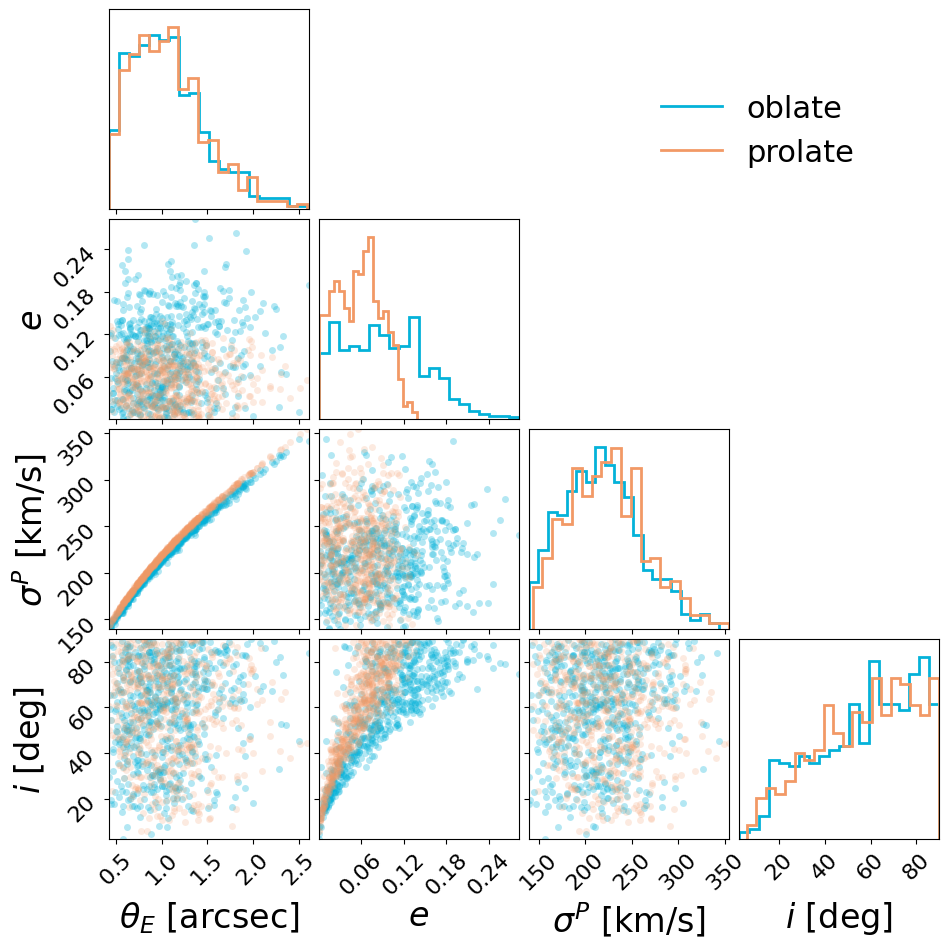

In [12]:
fig = corner_plot_both_seperate(data_kin_oblate, data_kin_prolate)
# plt.savefig('../plots/corner_plot_mock_kin_data.pdf', bbox_inches='tight', dpi=300)

In [13]:
def corner_plot_with_cut(data, theta_e_cut):

    data_plot = deepcopy(data)

    hist2dkwargs = {'plot_density':False, 'plot_contours':False, 'plot_datapoints': True, 'color': clist[0], 'data_kwargs': {'ms': 5, 'alpha': 0.3}}

    fig = corner.corner(data_plot.T,  labels=[r'$\theta_E$ [arcsec]', '$e$', r'$\sigma^P$ [km/s]' ,r'$i$ [deg]'], label_kwargs={'fontsize': 22}, **hist2dkwargs, hist_kwargs={'linewidth': 2, 'density' : True})

    # fig = corner.corner(data_plot.T,  labels=[r'$\theta_E$', '$e$', r'$\sigma^P$' ,r'$i$'], label_kwargs={'fontsize': 30}, **hist2dkwargs, hist_kwargs={'linewidth': 2, 'density' : True})

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=16)

    theta_e_list = data_plot[0, :]
    ind = theta_e_list >= theta_e_cut
    cut_data = data_plot[:, ind]
    print(np.sum(ind))

    cut_hist2dkwargs = {'plot_density':False, 'plot_contours':False, 'plot_datapoints': True, 'color': clist[2], 'data_kwargs': {'ms': 5, 'alpha': 0.3}}

    corner.corner(cut_data.T, fig=fig, **cut_hist2dkwargs, hist_kwargs={'linewidth': 2, 'density' : True})

    plt.plot([], [], color = clist[0], lw = 2, label = 'random projection')
    plt.plot([], [], color = clist[2], lw = 2, label = r'with $\theta_E \geq {}$ cut' .format(theta_e_cut))

    fig.legend(bbox_to_anchor=(0., 0.9, 0.93 ,0), fontsize=21, frameon=False)

    print("median inclination angle: ", np.median(data_plot[-1, :]), np.median(cut_data[-1, :]))
    print("median ellipticity: ", np.median(data_plot[1, :]), np.median(cut_data[1, :]))


    return fig

153
median inclination angle:  61.168500618100836 68.46832800513087
median ellipticity:  0.08791165370455478 0.10812622921604824


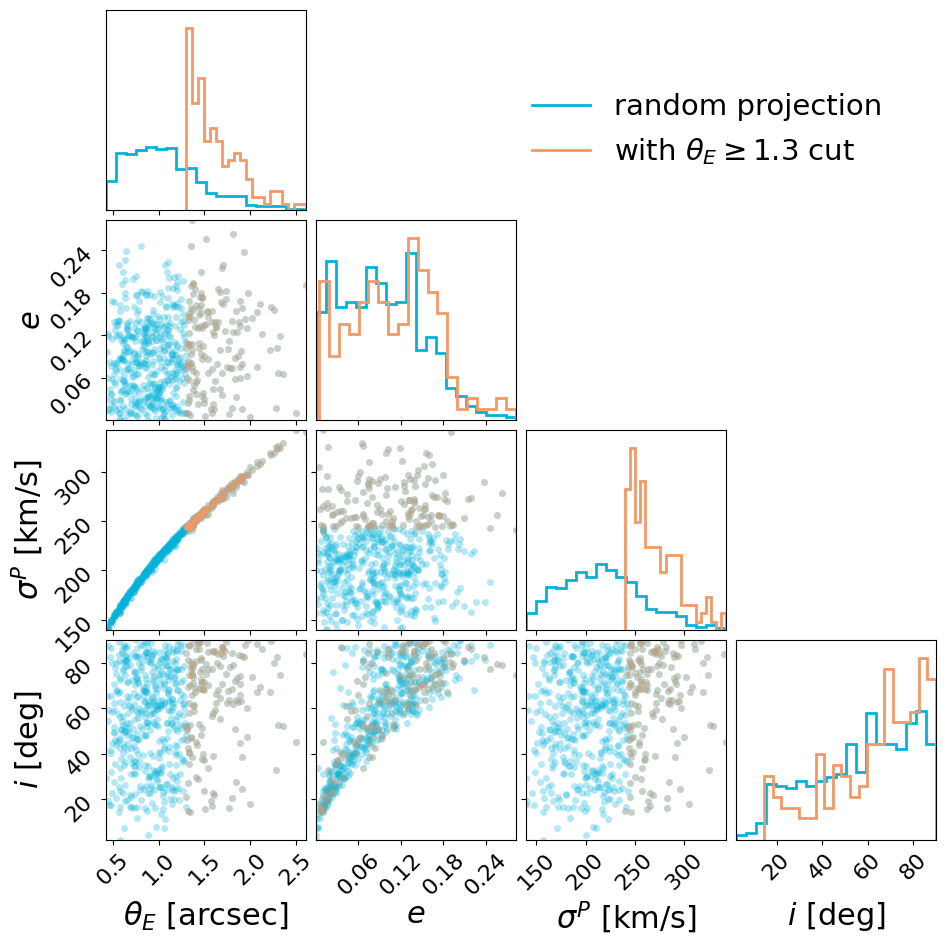

In [14]:
fig = corner_plot_with_cut(data_kin_oblate, 1.3)

162
median inclination angle:  60.117917310517306 59.933429572719135
median ellipticity:  0.05870811756830963 0.0532011851912217


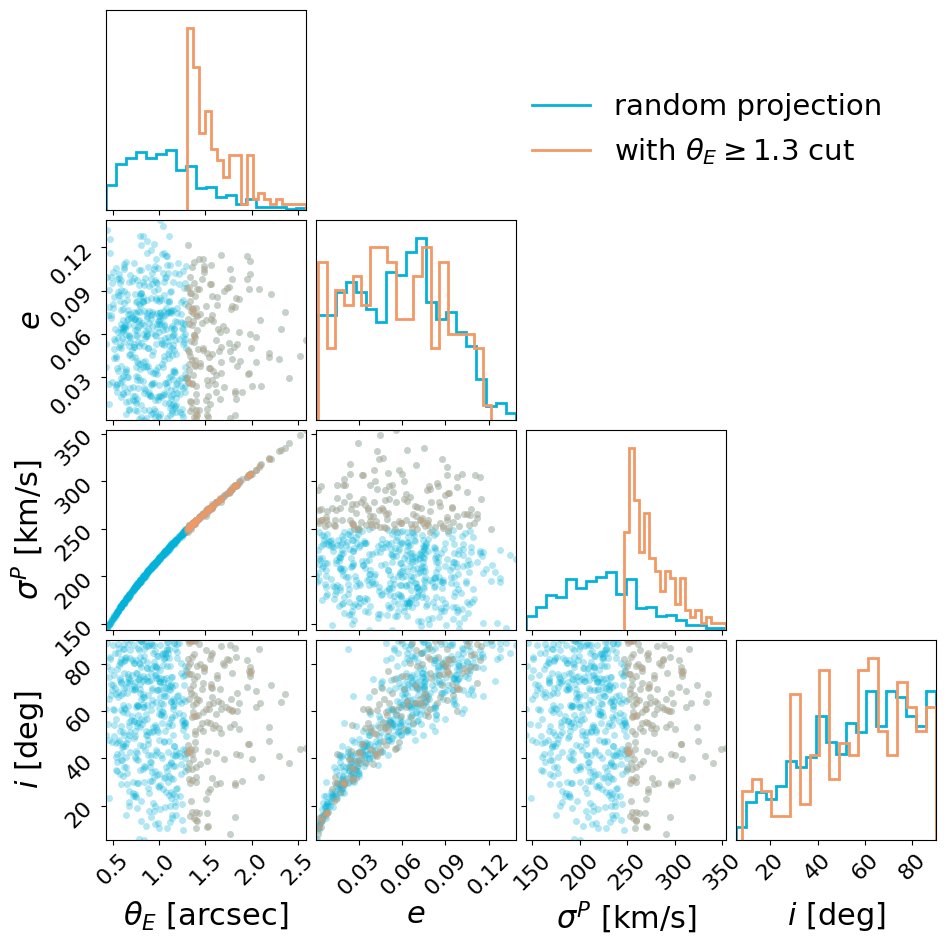

In [15]:
fig = corner_plot_with_cut(data_kin_prolate, 1.3)

In [16]:
def corner_plot_weighted(data):

    data_plot = deepcopy(data)

    theta_e_list = data_plot[0, :]

    weights = theta_e_list**2

    hist2dkwargs = {'plot_density':False, 'plot_contours':False, 'plot_datapoints': True, 'color': clist[0], 'data_kwargs': {'ms': 5, 'alpha': 0.3}}

    fig = corner.corner(data_plot.T,  labels=[r'$\theta_E$ [arcsec]', '$e$', r'$\sigma^P$ [km/s]' ,r'$i$ [deg]'], label_kwargs={'fontsize': 22}, **hist2dkwargs, hist_kwargs={'linewidth': 2, 'density' : True})

    hist2dkwargs_weighted = {'plot_density':False, 'plot_contours':False, 'plot_datapoints': True, 'color': clist[2], 'data_kwargs': {'ms': 5, 'alpha': 0.3}}

    corner.corner(data_plot.T, fig=fig, weights = weights, **hist2dkwargs_weighted, hist_kwargs={'linewidth': 2, 'density' : True})

    plt.plot([], [], color = clist[0], lw = 2, label = 'random projection')
    plt.plot([], [], color = clist[2], lw = 2, label = r'with $\theta_E^2$ weighting')

    fig.legend(bbox_to_anchor=(0., 0.9, 0.93 ,0), fontsize=21, frameon=False)

    return fig

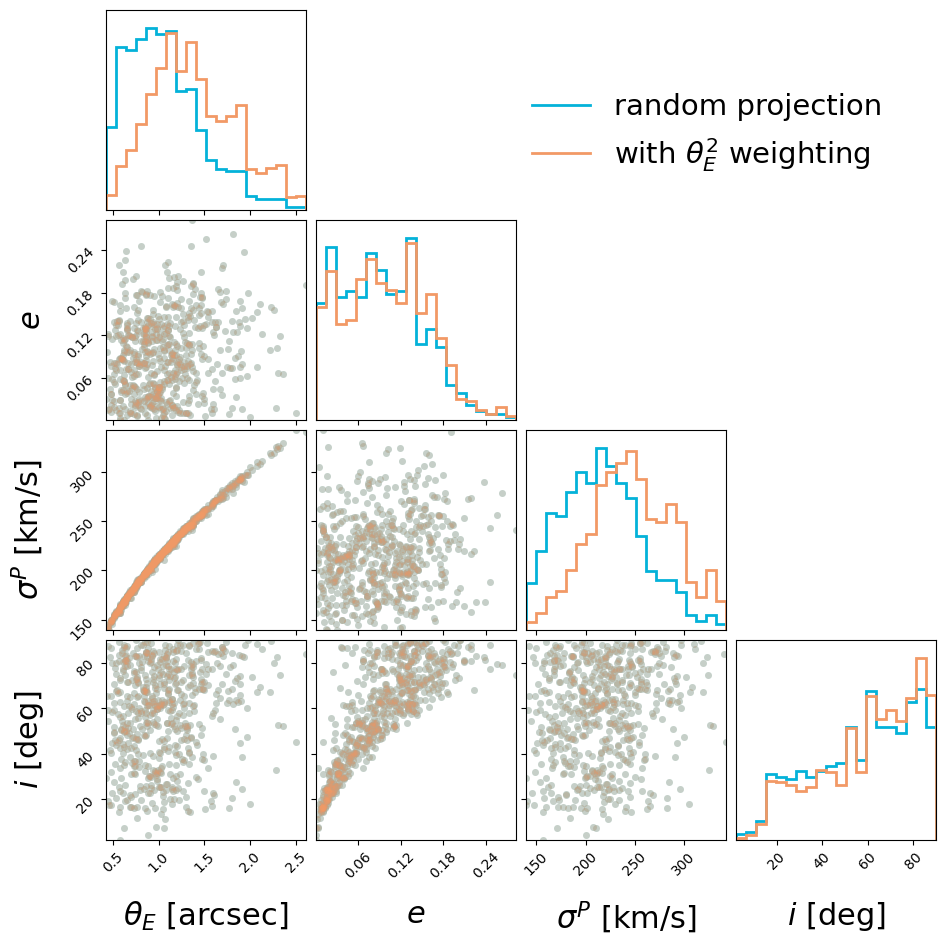

In [17]:
fig = corner_plot_weighted(data_kin_oblate)

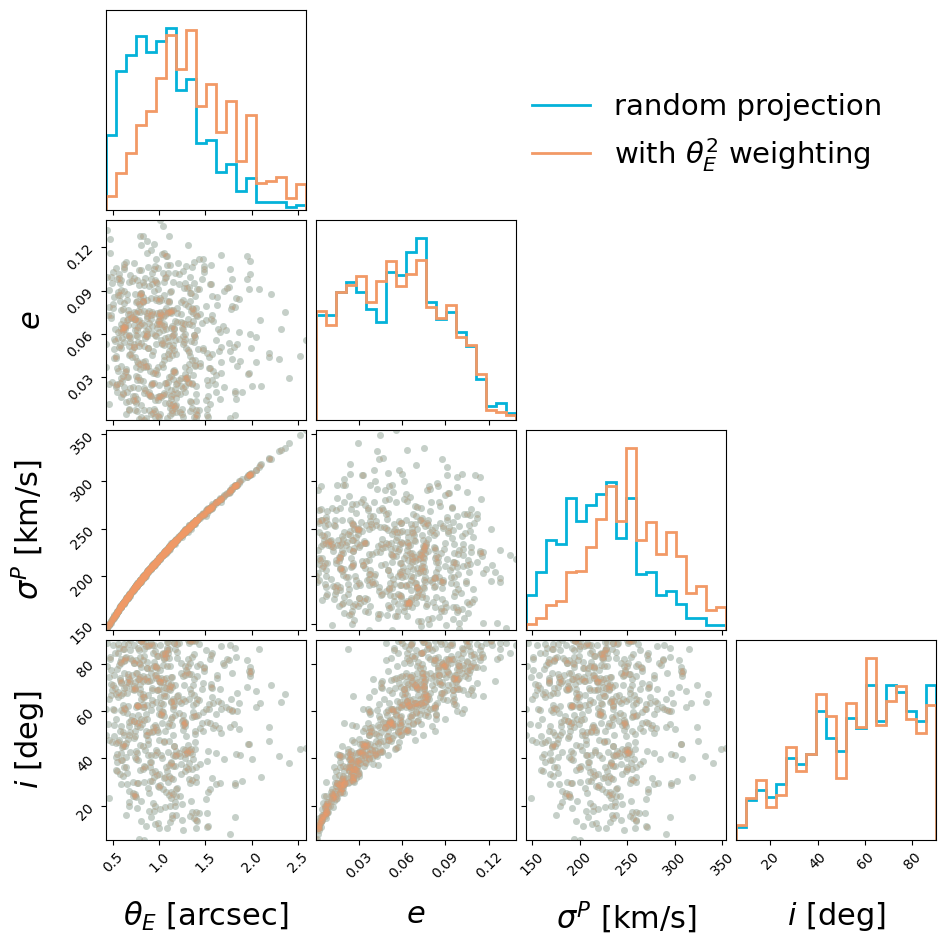

In [18]:
fig = corner_plot_weighted(data_kin_prolate)

In [19]:
def plot_both_with_weighting(data_oblate, data_prolate):

    clist = ["#04B2D9", "#8cba51", "coral", "mediumpurple"]
    handles = []
    sample_name = ["oblate", "prolate"]

    for j, data in enumerate([data_oblate, data_prolate]):

        data_plot = deepcopy(data)

        color_unweighted = clist[2 * j]
        color_weighted = clist[2 * j + 1]

        weights = data_plot[0, :] ** 2

        hist2dkwargs = {
            "plot_density": False,
            "plot_contours": False,
            "plot_datapoints": True,
            "color": color_unweighted,
            "data_kwargs": {"ms": 5, "alpha": 0.2},
        }

        if j == 0:
            fig = corner.corner(
                data_plot.T,
                labels=[r'$\theta_E$ [arcsec]', '$e$', r'$\sigma^P$ [km/s]' ,r'$i$ [deg]'],
                label_kwargs={"fontsize": 24},
                **hist2dkwargs,
                hist_kwargs={
                    "linewidth": 2,
                    "density": True,
                    "alpha": 0.8,
                    # "histtype": "bar",
                    "edgecolor": color_unweighted,
                },
                bins=10
            )
        else:
            corner.corner(
                data_plot.T,
                fig=fig,
                **hist2dkwargs,
                hist_kwargs={
                    "linewidth": 2,
                    "density": True,
                    "alpha": 0.8,
                    # "histtype": "bar",
                    "edgecolor": color_unweighted,
                },
                bins=10
            )

        for ax in fig.get_axes():
            ax.tick_params(axis="both", labelsize=16)


        cut_hist2dkwargs = {
            "plot_density": False,
            "plot_contours": False,
            "plot_datapoints": True,
            "color": color_weighted,
            "data_kwargs": {"ms": 5, "alpha": 0.3},
        }

        corner.corner(
            data_plot.T,
            fig=fig,
            weights=weights,
            **cut_hist2dkwargs,
            hist_kwargs={
                "linewidth": 2,
                "density": True,
                "alpha": 0.8,
                # "histtype": "bar",
                "edgecolor": color_weighted,
            },
            bins=10
        )


        axes = np.array(fig.axes).reshape((4, 4))


        handles.append(
            axes[0, 0].plot(
                [],
                [],
                lw=2,
                ls="-",
                color=color_unweighted,
                label="random projection, {}".format(sample_name[j]),
                marker=" ",
            )[0]
        )
        handles.append(
            axes[0, 0].plot(
                [],
                [],
                lw=2,
                ls="-",
                color=color_weighted,
                label=r"with $\theta_E^2$ weighting, {}".format(sample_name[j]),
                marker=" ",
            )[0]
        )

    fig.legend(
        handles=handles, bbox_to_anchor=(0.0, 0.98, 1., 0), fontsize=22, frameon=False
    )

    return fig

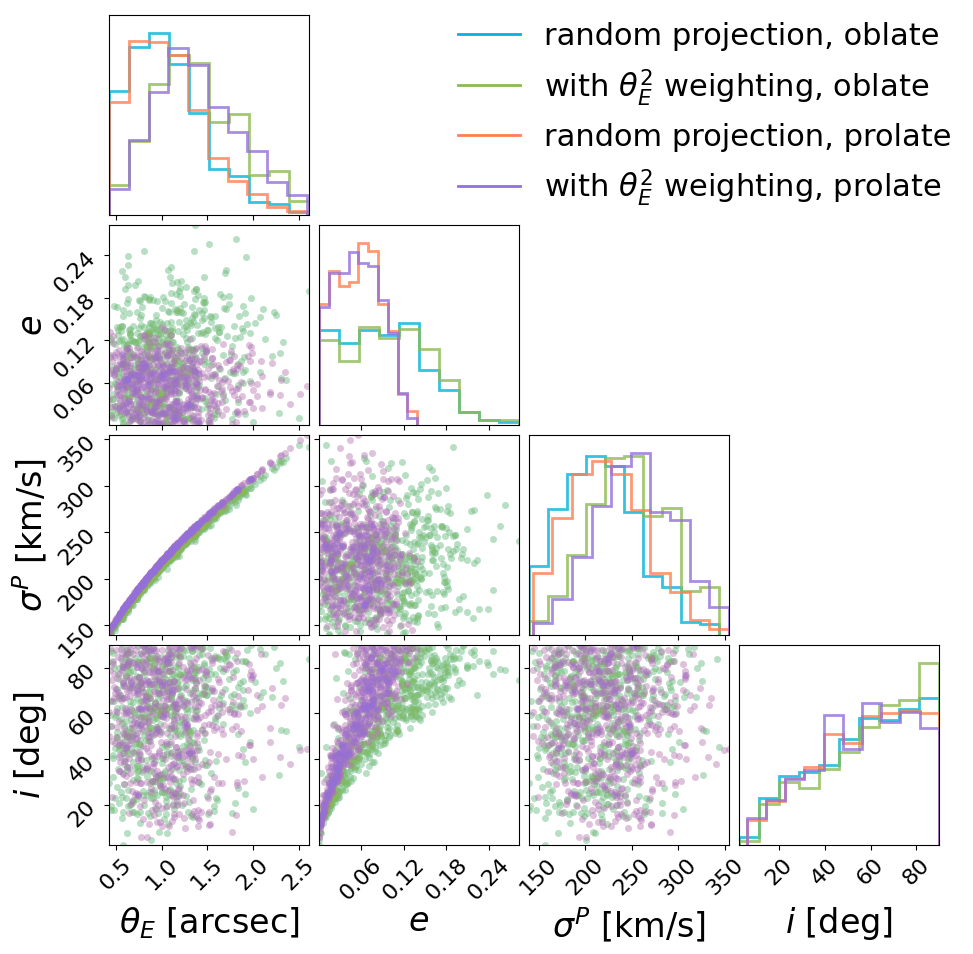

In [20]:
fig = plot_both_with_weighting(data_kin_oblate, data_kin_prolate)

plt.savefig('../plots/corner_plot_mock_kin_data_both.pdf', bbox_inches='tight')


In [21]:
# def plot_ellipticity_vs_threshold(data, theta_e_cut):

#     data_plot = deepcopy(data)

#     theta_e_list = data_plot[0, :]

#     ellipticity_cut_mean = np.zeros_like(theta_e_cut)
#     ellipticity_cut_median = np.zeros_like(theta_e_cut)


#     inclination_cut_mean = np.zeros_like(theta_e_cut)
#     inclination_cut_median = np.zeros_like(theta_e_cut)

#     num_sel_all = np.zeros_like(theta_e_cut)

#     for i, theta_e in enumerate(theta_e_cut):
#         ind = theta_e_list >= theta_e
#         cut_data = data_plot[:, ind]
#         ellipticity_cut_mean[i] = np.mean(cut_data[1, :])
#         ellipticity_cut_median[i] = np.median(cut_data[1, :])
#         inclination_cut_mean[i] = np.mean(cut_data[3, :])
#         inclination_cut_median[i] = np.median(cut_data[3, :])
#         num_sel = np.sum(ind)
#         num_sel_all[i] = num_sel

#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#     print(num_sel_all)

#     axs[0].scatter(theta_e_cut, ellipticity_cut_mean,  c=clist[0], s = num_sel_all/2, alpha = 0.5, edgecolor='none')
#     axs[0].plot(theta_e_cut, ellipticity_cut_mean, ls= '-', label = 'mean, selected', c=clist[0], marker='.')
#     axs[0].scatter(theta_e_cut, ellipticity_cut_median,  c=clist[2], s = num_sel_all/2, alpha = 0.5, edgecolor='none')
#     axs[0].plot(theta_e_cut, ellipticity_cut_median, ls= '-', label = 'median, selected', c=clist[2], marker='.')
#     axs[0].axhline(np.median(data_plot[1, :]),  linestyle='--', label = 'median, all', c=clist[2])
#     axs[0].axhline(np.mean(data_plot[1, :]),  linestyle=':', label = 'mean, all', c=clist[0])
#     axs[0].set_xlabel(r'$\theta_E$ cut [arcsec]', size = 16)
#     axs[0].set_ylabel(r'$e$', size = 16)

#     axs[1].scatter(theta_e_cut, inclination_cut_mean, c=clist[0], s = num_sel_all/2, alpha = 0.5, edgecolor='none')
#     axs[1].plot(theta_e_cut, inclination_cut_mean, ls= '-', label = 'mean, selected', c=clist[0], marker='.')
#     axs[1].scatter(theta_e_cut, inclination_cut_median,  c=clist[2], s = num_sel_all/2, alpha = 0.5, edgecolor='none')
#     axs[1].plot(theta_e_cut, inclination_cut_median, ls='-', label = 'median, selected', c=clist[2], marker = '.')
#     axs[1].axhline(np.median(data_plot[3, :]), linestyle='--', label = 'median, all', c=clist[2])
#     axs[1].axhline(np.mean(data_plot[3, :]),  linestyle=':', label = 'mean, all', c=clist[0])
#     axs[1].set_xlabel(r'$\theta_E$ cut [arcsec]', size = 16)
#     axs[1].set_ylabel(r'$i$ [deg]', size = 16)

#     for ax in axs:
#         ax.set_box_aspect(0.8)
#         ax.tick_params(axis='both', labelsize=12)
    
#     dummy_lines = []
#     dummy_lines.append(plt.Line2D([0], [0], color=clist[0], marker='o', markersize=5, linestyle='-', label='mean, selected'))
#     dummy_lines.append(plt.Line2D([0], [0], color=clist[2], marker='o', markersize=5, linestyle='-', label='median, selected'))
#     dummy_lines.append(plt.Line2D([0], [0], color=clist[0], linestyle=':', label='mean, all'))
#     dummy_lines.append(plt.Line2D([0], [0], color=clist[2], linestyle='--', label='median, all'))

#     fig.legend(handles=dummy_lines, loc='center right', fontsize=14, bbox_to_anchor=(1.15, 0.5), frameon=False)

#     fig.show()



In [22]:
# plot_ellipticity_vs_threshold(data_kin_oblate, np.linspace(0.5, 2.2, 20))

In [23]:
# plot_ellipticity_vs_threshold(data_kin_prolate, np.linspace(0.5, 2.2, 20))

In [24]:
# def plot_ellipticity_vs_threshold_both(data_oblate, data_prolate, theta_e_cut):

#     fig = plt.figure(figsize = (11, 7))
#     gs = fig.add_gridspec(2, 2, hspace=0.05, wspace = 0.25)
#     axs = gs.subplots(sharex='col')
#     axs = axs.flatten()

#     for j, data in enumerate([data_oblate, data_prolate]):

#         data_plot = deepcopy(data)

#         theta_e_list = data_plot[0, :]

#         ellipticity_cut_mean = np.zeros_like(theta_e_cut)
#         ellipticity_cut_median = np.zeros_like(theta_e_cut)


#         inclination_cut_mean = np.zeros_like(theta_e_cut)
#         inclination_cut_median = np.zeros_like(theta_e_cut)

#         num_sel_all = np.zeros_like(theta_e_cut)

#         for i, theta_e in enumerate(theta_e_cut):
#             ind = theta_e_list >= theta_e
#             cut_data = data_plot[:, ind]
#             ellipticity_cut_mean[i] = np.mean(cut_data[1, :])
#             ellipticity_cut_median[i] = np.median(cut_data[1, :])
#             inclination_cut_mean[i] = np.mean(cut_data[3, :])
#             inclination_cut_median[i] = np.median(cut_data[3, :])
#             num_sel = np.sum(ind)
#             num_sel_all[i] = num_sel

#         print(num_sel_all)

#         axs[2*j].scatter(theta_e_cut, ellipticity_cut_mean,  c=clist[0], s = num_sel_all/2, alpha = 0.5, edgecolor='none')
#         axs[2*j].plot(theta_e_cut, ellipticity_cut_mean, ls= '-', label = 'mean, selected', c=clist[0], marker='.')
#         axs[2*j].scatter(theta_e_cut, ellipticity_cut_median,  c=clist[2], s = num_sel_all/2, alpha = 0.5, edgecolor='none')
#         axs[2*j].plot(theta_e_cut, ellipticity_cut_median, ls= '-', label = 'median, selected', c=clist[2], marker='.')
#         axs[2*j].axhline(np.median(data_plot[1, :]),  linestyle='--', label = 'median, all', c=clist[2])
#         axs[2*j].axhline(np.mean(data_plot[1, :]),  linestyle='--', label = 'mean, all', c=clist[0])
#         # axs[2*j].set_xlabel(r'$\theta_E$ cut [arcsec]', size = 16)
#         axs[2*j].set_ylabel(r'$e$', size = 16)

#         axs[2*j+1].scatter(theta_e_cut, inclination_cut_mean, c=clist[0], s = num_sel_all/2, alpha = 0.5, edgecolor='none')
#         axs[2*j+1].plot(theta_e_cut, inclination_cut_mean, ls= '-', label = 'mean, selected', c=clist[0], marker='.')
#         axs[2*j+1].scatter(theta_e_cut, inclination_cut_median,  c=clist[2], s = num_sel_all/2, alpha = 0.5, edgecolor='none')
#         axs[2*j+1].plot(theta_e_cut, inclination_cut_median, ls='-', label = 'median, selected', c=clist[2], marker = '.')
#         axs[2*j+1].axhline(np.median(data_plot[3, :]), linestyle='--', label = 'median, all', c=clist[2])
#         axs[2*j+1].axhline(np.mean(data_plot[3, :]),  linestyle='--', label = 'mean, all', c=clist[0])
#         # axs[1].set_xlabel(r'$\theta_E$ cut [arcsec]', size = 16)
#         axs[2*j+1].set_ylabel(r'$i$ [deg]', size = 16)

#     axs[1].sharex(axs[3])
#     axs[0].sharex(axs[2])
#     props = dict(boxstyle = 'square', facecolor = 'lightgray', alpha = 0.3, edgecolor = 'None')

#     for i, ax in enumerate(axs):
#         # ax.set_box_aspect(0.8)
#         ax.tick_params(axis='both', labelsize=12)
#         if i in [0, 1]:
#             ax.text(0.1, 0.9, 'oblate', transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props)
#         if i in [2, 3]:
#             ax.text(0.1, 0.2, 'prolate', transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props)
#             ax.set_xlabel(r'$\theta_E$ cut [arcsec]', size = 16)

    
#     dummy_lines = []
#     dummy_lines.append(plt.Line2D([0], [0], color=clist[0], marker='o', markersize=5, linestyle='-', label='mean, with cut'))
#     dummy_lines.append(plt.Line2D([0], [0], color=clist[2], marker='o', markersize=5, linestyle='-', label='median, with cut'))
#     dummy_lines.append(plt.Line2D([0], [0], color=clist[0], linestyle='--', label='mean, all'))
#     dummy_lines.append(plt.Line2D([0], [0], color=clist[2], linestyle='--', label='median, all'))

#     fig.legend(handles=dummy_lines, loc='lower center', fontsize=16, bbox_to_anchor=(0.5, -0.1), frameon=True, ncols=2)

#     return fig

In [25]:
# fig = plot_ellipticity_vs_threshold_both(data_kin_oblate, data_kin_prolate, np.linspace(0.5, 2., 20))
# # plt.savefig('../plots/ellipticity_vs_thetaE_cut.pdf', bbox_inches='tight', dpi=300)
# plt.show()